# Бэггинг и случайный лес

In [33]:
from sklearn import cross_validation, datasets, metrics, tree, ensemble
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
matplotlib.style.use('ggplot')
%matplotlib inline

** Загрузим датасет digits из sklearn.datasts. Подготовим матрицу признаков X и ответы на обучающей выборке y.**

In [9]:
digits = datasets.load_digits()

In [10]:
y= digits.target
X= digits.data

Для оценки качества далее будем использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Использем k=10, чтобы полученные оценки качества имели небольшой разброс, и было проще проверить полученные ответы. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) используем метод .mean() у массива, который возвращает cross_val_score.

In [15]:
def kachestvo(estimator):
    return cross_validation.cross_val_score(estimator,X,y,cv=10).mean()

def write_answer(res, i):
    with open('bagging_{}.txt'.format(i), 'w') as f:
        f.write(str(kachestvo(res)))

** 1. Создадим DecisionTreeClassifier с настройками по умолчанию и измерим качество его работы. Ответ запишем. **

In [16]:
clf = tree.DecisionTreeClassifier(random_state=1)
write_answer(clf, 1)

** 2. Воспользуемся BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используем в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100. Оценим качество, ответ запишем. **

In [17]:
clf2= ensemble.BaggingClassifier(n_estimators=100)
write_answer(clf2, 2)

** 3. Теперь выберем параметры BaggingClassifier такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на $$\sqrt d$$случайных признаков. Качество работы получившегося классификатора - ответ в пункте 3. Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три.**

In [18]:
n_features= X.shape[1]
clf3=ensemble.BaggingClassifier(n_estimators=100, max_features=int(np.sqrt(n_features)))
write_answer(clf3, 3)

** 4. Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Выбираем опять же $$\sqrt d$$ признаков. Качество полученного классификатора на контрольной выборке и будет ответом в пункте 4. **

In [19]:
clf4=ensemble.BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(max_features='sqrt'), n_estimators=100)
write_answer(clf4, 4)

** Полученный в пункте 4 классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble. Сделаем это, а затем изучим, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева.** .

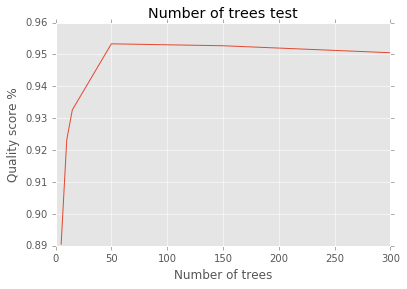

In [34]:
x_labels = []
y_labels = []
for i in [5, 10, 15, 50, 150, 300]:
    x_labels.append(i)
    rand_forest = ensemble.RandomForestClassifier(n_estimators=i)
    y_labels.append(kachestvo(rand_forest))
    
plt.plot(x_labels, y_labels)
plt.title('Number of trees test')
plt.xlabel('Number of trees')
plt.ylabel('Quality score %')
plt.show()


In [ ]:
x_labels = []
y_labels = []
for i in range(4, 60):
    x_labels.append(i)
    rand_forest = ensemble.RandomForestClassifier(max_features=i)
    y_labels.append(kachestvo(rand_forest))
    
plt.plot(x_labels, y_labels)
plt.title('Max features test')
plt.xlabel('Number of features')
plt.ylabel('Quality score %')
plt.show()

In [ ]:
x_labels = []
y_labels = []
for i in rrange(4, 30):
    x_labels.append(i)
    rand_forest = ensemble.RandomForestClassifier(max_depth=i)
    y_labels.append(kachestvo(rand_forest))
    
plt.plot(x_labels, y_labels)
plt.title('Max depth test')
plt.xlabel('Depth')
plt.ylabel('Quality score %')
plt.show()

** На основе наблюдений делаем вывод: **

a. При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев

b. С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.

c. При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.

d. При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).